# Predicting Road Accidents

Luis Terán

## 1. Problem statement

<p style="text-align:justify">Motor vehicle accidents continue to be one of the leading causes of accidental deaths and injuries in the United States. They are responsible for billions in property damage and other economic losses each year. More than 38,000 people die every year in crashes on U.S. roadways. The U.S. traffic fatality rate is 12.4 deaths per 100,000 inhabitants. An additional 4.4 million are injured seriously enough to require medical attention. Road crashes are the leading cause of death in the U.S. for people aged 1-54 (ASIRT, 2020). </p>

<p style="text-align:justify"> In order to identify the cause of the problem, the aim of this project is to identify those factors that influence the most on cars accidents and have a quantitatively estimate of the significance the relationship between the factors and the road accidents.</p>

<p style="text-align:justify">Even though this is a sample data from Seattle, this behavior patterns in car accidents can be related to other states or even countries with less amount of data of this problem. So this can be used as a feature reference for prevention of car accidents in all other places.</p>

## 2. Data wrangling

### 2.1 Importing the dataset

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

%matplotlib inline

The original dataset was obtained from the Seattle’s government page at:

- <https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d> 

The dataset if available for public access. It was created in April 8, 2020 and last update register is from August 27, 2020. Further information of the dataset is available in:

- <https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf>


In [92]:
np.random.seed(12345)

In [93]:
df = pd.read_csv("Collisions.csv")
df.head(3)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1.256033e+06,240501.215914,1,332176,333676,EA40602,Matched,Intersection,26581.0,28TH AVE W AND W DRAVUS ST,...,Dry,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N
1,1.282438e+06,223443.774169,2,328504,330004,EA10294,Unmatched,Block,NaN,LAKE WASHINGTON BLVD BETWEEN LAKESIDE AVE AND ...,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
2,1.269233e+06,229465.525407,3,329091,330591,EA15604,Matched,Block,NaN,WESTLAKE AVE N BETWEEN DENNY WAY AND JOHN ST,...,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N


A first view of the data is displayed, it consists of a set of 40 variables with 220937 observations:

The data is split iinto

<p style="text-align:justify"> Before selecting the features for predicting it was necessary to state our main prediction objective. We want to know the probability and magnitude of an accident given some characteristics, in this way, the **"VEHCOUNT", “INJURIES”, "SERIOUS INJURIES", "FATALITIES"** variable could be helpful for measuring in some way the severity of accident. These columns represent:</p>

- VEHCOUNT: Number of vehicles involved in an accident
- INJURIES: Number of injured persons
- SERIOUS INJURIES: Number of people with serious injuries
- FATALITIES: Fatalities occured

<p style="text-align:justify"> The complete dataset was split into two different dataframes. The first one was for feature selection, those variables that can contribute to an accident were selected and joined to this dataframe. On the other hand, there were selected other variables for additional information. The aim of this dataset is for getting a better understanding of the data and the problem.</p>


In [94]:
features = ['UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'VEHCOUNT', 'INJURIES','SERIOUSINJURIES','FATALITIES']
additionalInfo = ['X', 'Y', 'SEVERITYDESC', 'COLLISIONTYPE', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 
                 'SERIOUSINJURIES', 'FATALITIES', 'INJURIES','SERIOUSINJURIES','FATALITIES']

In [95]:
dfInfo = df[additionalInfo].copy()
df = df[features].copy()

In [96]:
df.head()

,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
0,N,Overcast,Dry,Daylight,NaN,2,1,0,0
1,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,N,Clear,Dry,Daylight,NaN,2,0,0,0
3,N,Raining,Wet,Dark - Street Lights On,NaN,4,0,0,0
4,N,Clear,Dry,Daylight,NaN,2,1,0,0


### 2.2 Null values

Before we start with the pre-processing process we first need to take care of NULL values. A NULL value in a table is a value in a field that appears to be blank. We first need to know the amount of the NULL values in the dataset to understand how these NULL values are affecting the dataset.

In [97]:
nulls = df.isna().sum().to_frame()
nulls.columns = ['Null count']
nulls['Null percentage'] = nulls['Null count']/(df.shape[0])*100
nulls.T

,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
Null count,26251.000000,26460.000000,26380.000000,26548.000000,211039.00000,0.0,0.0,0.0,0.0
Null percentage,11.881668,11.976265,11.940055,12.016095,95.51999,0.0,0.0,0.0,0.0


<p style="text-align:justify"> As we see, for most of the columns there is about a 12% of NULL values. The exception to this rule are the "SEVERITYCODE" column but especially the "SPEEDING" column that has over a 95% of NULL values, this will be explain later. For now, since our NULL values in the data are not a significant amount and considering the number of observations in the dataset, we can drop the whole row with presence of NULL values on it for simplicity, exluding those present in the "SPEEDING" column. We still get 194209 observations out of the 220937 observations in the original dataset (about 88% of the data). </p>

In [98]:
df.dropna(subset=['UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','VEHCOUNT','INJURIES','SERIOUSINJURIES','FATALITIES'], 
          inplace = True)

In [99]:
df.shape

(194209, 9)

<p style="text-align:justify"> Furthermore, now the data needs to be in a format such that the Machine Learning algorithms can process it. For that, the categorical data needs to be transformed into an integer equivalent. First, we need to transform all categorical data into a defined values for every parameter</p>

In [100]:
df.dtypes.to_frame().T

,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
0,object,object,object,object,object,int64,int64,int64,int64


### 2.3 Influence of drugs or alcohol

In [101]:
df['UNDERINFL'].value_counts().to_frame()

,UNDERINFL
N,102948
0,81658
Y,5373
1,4230


Consequently, is necessary to do the same for the "UNDERINFL" column. In this case, the result should be "0" for no influence of drugs or alcohol and "1" for influence. Instead we have a combination between 0/1 and Y/N observations. We will replace all the character observations to their corresponding number.

In [102]:
# Replacing 3's for 4's
df['UNDERINFL'].replace('N', '0', inplace = True)
# Replacing 2b's for 3's
df['UNDERINFL'].replace('Y', '1', inplace = True)
# Converting the string values to integers
df['UNDERINFL'].astype(int)
# New set of values
df['UNDERINFL'].value_counts().to_frame()

,UNDERINFL
0,184606
1,9603


### 2.4 Weather

In [103]:
df['WEATHER'].value_counts().to_frame()

,WEATHER
Clear,114157
Raining,33974
Overcast,28461
Unknown,15079
Snowing,913
Other,843
Fog/Smog/Smoke,576
Sleet/Hail/Freezing Rain,116
Blowing Sand/Dirt,55
Severe Crosswind,26


The weather is represented by a lot categorical values that are needed to transfom into integer values. For the transformation, a dictionary was created containing all the numerical and what they represent. For the case of the weather, the numerical values represent:

1. Clear
2. Raining
3. Overcast
4. Snowing
5. Fog/Smog/Smoke
6. Sleet/Hail/Freezing Rain
7. Blowing Sand/Dirt
8. Severe Crosswind
9. Partly Cloudy
10. Other or unknown

In [104]:
# Dictionary of reference for replacement in weather
cleanup_nums = {"WEATHER": {"Clear": 1, "Partly Cloudy": 2, "Overcast": 3, "Raining": 4,
                             "Severe Crosswind": 5, "Sleet/Hail/Freezing Rain": 6, "Snowing": 7, 
                            "Fog/Smog/Smoke": 8, "Blowing Sand/Dirt": 9, "Other": 10, "Unknown": 10}}
# Replacing all the ellements for the defined numbers in the dictionary
df.replace(cleanup_nums, inplace = True)
# Converting the string values to integers
df['UNDERINFL'] = df['UNDERINFL'].astype(int)

### 2.5 Road condition

In [105]:
df['ROADCOND'].value_counts().to_frame()

,ROADCOND
Dry,127863
Wet,48634
Unknown,15081
Ice,1228
Snow/Slush,1009
Other,135
Standing Water,119
Sand/Mud/Dirt,76
Oil,64


In the case of the "ROADCOND" column, its values are all categorical and need to be transformed into integer numbers as mentioned before. This will be made by the following dictionary.

1. Dry
2. Wet
3. Ice
4. Snow/Slush
5. Standing water
6. Sand/Mud/Dirt
7. Oil
8. Other/Unknown


In [106]:
# Dictionary of reference for replacement in weather
cleanup_nums = {"ROADCOND": {"Dry": 1, "Sand/Mud/Dirt": 2, "Wet": 3, "Standing Water": 4,  "Snow/Slush": 5, 
                             "Ice": 6, "Oil": 7, "Other": 8, "Unknown": 8}}
# Replacing all the ellements for the defined numbers in the dictionary
df.replace(cleanup_nums, inplace = True)
# Converting the string values to integers
df['ROADCOND'] = df['ROADCOND'].astype(int)

### 2.6 Light condition

In [107]:
df['LIGHTCOND'].value_counts().to_frame()

,LIGHTCOND
Daylight,119018
Dark - Street Lights On,49969
Unknown,13502
Dusk,6061
Dawn,2596
Dark - No Street Lights,1571
Dark - Street Lights Off,1229
Other,243
Dark - Unknown Lighting,20


In the same way as happened with the previous columns, the "LIGHTCOND" column need to be transformed into integer numbers through a dictionary with the following representative  values.

1. Daylight
2. Dark – Street Lights On
3. Unknown
4. Dusk
5. Dawn
6. Dark – No Street Lights
7. Dark – Street Lights On
8. Dark – Unknown Lighting
9. Other


In [108]:
# Dictionary of reference for replacement in weather
cleanup_nums = {"LIGHTCOND": {"Daylight": 1, "Dawn": 2, "Dusk": 3, "Dark - Street Lights On": 4, 
                              "Dark - Unknown Lighting": 7, "Dark - Street Lights Off": 6,
                              "Dark - No Street Lights": 5,"Other": 8, "Unknown": 8}}
# Replacing all the ellements for the defined numbers in the dictionary
df.replace(cleanup_nums, inplace = True)
# Converting the string values to integers
df['LIGHTCOND'] = df['LIGHTCOND'].astype(int)

### 2.7 Speeding

In [109]:
df['SPEEDING'].value_counts().to_frame()

,SPEEDING
Y,9881


For the last feature, we can see that it has only one value with a very few counts. Since it is a boolean variable, it coulb be interpreted that all the missing values are the opposite case of the filled ones. For that reason, all the missing values are defined as "0". Also the string values of "Y" are trasformed into its equivalent "1".

In [110]:
# Replacing all null values with 0
df.loc[(~(df['SPEEDING'] == 'Y')), 'SPEEDING'] = 0
# Replacing Y's to 1's
df['SPEEDING'].replace('Y', '1', inplace = True)
# Converting the string values to integers
df['SPEEDING'] = df['SPEEDING'].astype(int)

In [111]:
df['SPEEDING'].value_counts().to_frame()

,SPEEDING
0,184328
1,9881


### 2.8 Severity of the accident

For the measurement of the probability of the severity of the damage we need a way to evaluate the total damage. This can be made by the total contribution of injuries, fatalities and involved vehicles. Also, this can be set with some weights for representing that some events cause more severity. For this case, we'll use the formula:

SEVERITY = CRASHED VEHICLES + 5\*INJURIES + 10\*SERIOUS INJURIES + 20\* FATALITIES

In [112]:
df['INJURIES'] = df['INJURIES'].astype(int)
df['SERIOUSINJURIES'] = df['SERIOUSINJURIES'].astype(int)
df['FATALITIES'] = df['FATALITIES'].astype(int)
df['VEHCOUNT'] = df['VEHCOUNT'].astype(int)

df['SEVERITY'] = df['VEHCOUNT'] + 5*df['INJURIES'] + 10*df['SERIOUSINJURIES'] + 20*df['FATALITIES']

By making these we would like to create different categories according to the output values in this column, getting a different type of severity for every input:

1. Type 1 (0 - 4): No incident or a few car crashes with no injuries or fatalities
2. Type 2 (5 - 9): One injured person and multiple car crashes
3. Type 3 (10 - 20): Multiple Injuries or a serious injured person, with multiple car crashes 
4. Type 4 (>20): Sever accident. A lot of injured persons, more than one serious injured person or a fatalitie occured

These range of values are defined as bins and labeled accordingly

In [113]:
type1 = 0
type2 = 5
type3 = 10
type4 = 20

df['SEV'] = pd.cut(df['SEVERITY'], bins=[type1, type2, type3, type4, float('Inf')], labels=['1', '2', '3', '4'])

Once the severity of the accident is classfied into categories, for further analysis is necessary to take care of NULL vaues present in this column. Verifying the column we can see that the null correspond to the type 1 accident (Any incident), so the values are replaced to the corresponding value (Type 1 = 1). Also, the values are transformed from categorical (String) to integers values (int).

In [114]:
df[df['SEV'].isnull()]

,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,SEVERITY,SEV
151332,0,1,1,1,0,0,0,0,0,0,NaN
162919,0,1,1,1,0,0,0,0,0,0,NaN
214842,0,1,1,1,0,0,0,0,0,0,NaN


In [115]:
df['SEV'] = df['SEV'].replace(np.nan, 1)
df['SEV'] = df['SEV'].astype(int)

## 3. Exploratory data analysis

In [116]:
df.head()

,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,SEVERITY,SEV
0,0,3,1,1,0,2,1,0,0,7,2
2,0,1,1,1,0,2,0,0,0,2,1
3,0,4,3,4,0,4,0,0,0,4,1
4,0,1,1,1,0,2,1,0,0,7,2
5,1,1,1,1,0,2,0,0,0,2,1


Now, we have a tidy dataset ready for analysis and machine learning processing. Now we can check how does the dataset variate. From the boxplot above, we can see that we expect that the most frequent variable are those with lower values, those values were defined un purpose like that for the most common weather, light and road conditions.
Also, we clearly see that some columns have almost for every case the same value. Those columns are: 
- Under Influence of alcohol or drugs: Almost all the cases correspond to 0 that means no influence at all.
- Speeding: Almost all the cases correspond to 0, that means no exceed in the speed limit.
- Vehcount: Almost all the cases only imply two cars in the accident.

For these columns there are more values, since there are just a few, those values are marked as outliers and are not shown in this plot

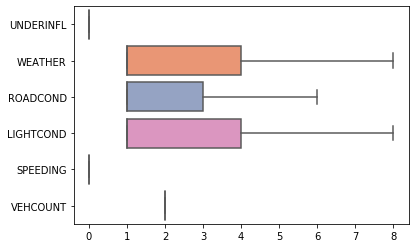

In [117]:
ax = sns.boxplot(data=df.iloc[:,:-5], orient="h", palette="Set2", showfliers = False)

### 3.1 Severity

One of the most important data columns in the dataset is the "Severity" column. From the plot below we can see the most of the values range between 0 and 12. Being the 50% of the data between 2 and 6 in the severity scale. This means almost all the values are in the type 1 and type 2 in the categorical scale of severity.

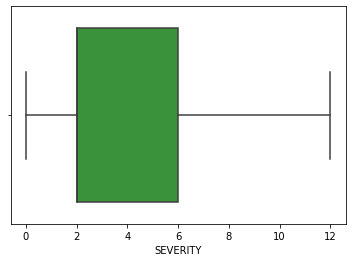

In [118]:
ax = sns.boxplot(x=df['SEVERITY'], showfliers = False, color = 'tab:green')

For better apreciation, the plot shows the difference in frequence of the types of categorical severity of the accident. As we told, type 1 and type 2 are the most frequent ones, this is telling that for most of the cases there are no injuries or just a few of them with no seriuos injuries or fatalities.

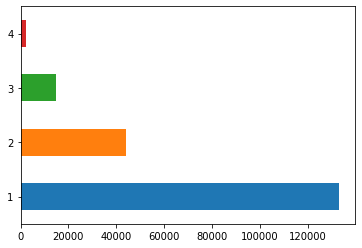

In [119]:
CountStatus = pd.value_counts(df['SEV'].values, sort=True)
CountStatus.plot.barh(colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive'])

We can check what are the most frequent Collision types present in the dataset. There are a lot of different collision type but he most frequent car accidents involved a parked car. Rear end and angles were also a very frequent collision type

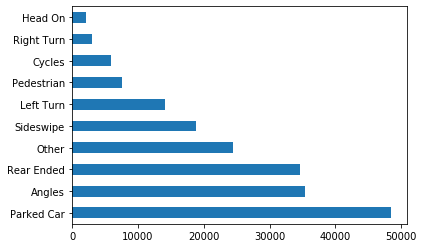

In [120]:
CountStatus = pd.value_counts(dfInfo['COLLISIONTYPE'].values, sort=True)
CountStatus.plot.barh()

Now looking to the severity description, we realize that the frequency labels and the frequency values on them look similar to the values proposed to the labels created with the involved vehicles, injuries and fatalities.

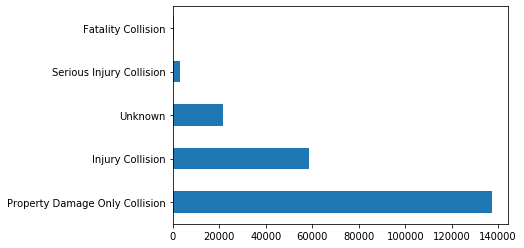

In [121]:
CountStatus = pd.value_counts(dfInfo['SEVERITYDESC'].values, sort=True)
CountStatus.plot.barh()

### 3.2 Under the influence of drugs or alcohol

In [122]:
total = (df.groupby(['UNDERINFL'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()).sum(axis=1).values
influence = df.groupby(['UNDERINFL'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()
influence.iloc[0,0:3] = influence.iloc[0,0:3].div(total[0]/100)
influence.iloc[1,0:3] = influence.iloc[1,0:3].div(total[1]/100)
influence

,INJURIES,SERIOUSINJURIES,FATALITIES
UNDERINFL,,,
0,96.040737,3.631232,0.328031
1,90.746934,7.612677,1.640389


From the analysis from the influence of drugs or alcohol, as expected, we detected that in case of accident, drunk or on drug people driving have a 4% extra of probability of having serious injuries and 1% more for death rate according to the observations in the dataset.

### 3.3 Weather

In [123]:
# Dictionary of reference for replacement in weather
cleanup_nums = {"WEATHER": {"Clear": 1, "Partly Cloudy": 2, "Overcast": 3, "Raining": 4,
                             "Severe Crosswind": 5, "Sleet/Hail/Freezing Rain": 6, "Snowing": 7, 
                            "Fog/Smog/Smoke": 8, "Blowing Sand/Dirt": 9, "Other": 10, "Unknown": 10}}

In [124]:
total = (df.groupby(['WEATHER'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()).sum(axis=1).values
weather = df.groupby(["WEATHER"])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()
for i in range(weather.shape[0]):
    weather.iloc[i,0:3] = weather.iloc[i,0:3].div(total[i]/100)
weather['Reported cases']=total
weather

,INJURIES,SERIOUSINJURIES,FATALITIES,Reported cases
WEATHER,,,,
1,95.444217,4.101322,0.454461,53690
2,100.000000,0.000000,0.000000,7
3,95.744188,3.831003,0.424809,12947
4,96.217595,3.460628,0.321778,16471
5,88.888889,0.000000,11.111111,9
6,96.078431,3.921569,0.000000,51
7,95.515695,4.484305,0.000000,223
8,96.654275,1.858736,1.486989,269
9,100.000000,0.000000,0.000000,17


From the Weahter analysis, we can conclude that the most dangerous weather for driving is "Severe Crosswind" (8) beacause from all the cases registered in this weather, 11.11% of cases ended up in fatalities. The least dangerous weather is "Partly cloudy" with only minor injuries in car accidents.

### 3.4 Road conditions

In [125]:
# Dictionary of reference for replacement in weather
cleanup_nums = {"ROADCOND": {"Dry": 1, "Sand/Mud/Dirt": 2, "Wet": 3, "Standing Water": 4,  "Snow/Slush": 5, 
                             "Ice": 6, "Oil": 7, "Other": 8, "Unknown": 8}}

In [126]:
total = (df.groupby(['ROADCOND'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()).sum(axis=1).values
roadCond = df.groupby(['ROADCOND'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()
for i in range(roadCond.shape[0]):
    roadCond.iloc[i,0:3] = roadCond.iloc[i,0:3].div(total[i]/100)
roadCond['Reported cases']=total
roadCond

,INJURIES,SERIOUSINJURIES,FATALITIES,Reported cases
ROADCOND,,,,
1,95.444009,4.079046,0.476945,59965
2,100.000000,0.000000,0.000000,28
3,96.132287,3.552949,0.314764,23192
4,92.857143,7.142857,0.000000,42
5,96.694215,3.305785,0.000000,242
6,94.890511,4.866180,0.243309,411
7,100.000000,0.000000,0.000000,35
8,96.650246,3.251232,0.098522,1015


In general, it seems that the road conditions are not very related to fatalities since we see very small proportion related to it. From the dataset of Seattle, the most sever accidents happened in "standing water" roads. On the other, surprinsingly most of the cases occured on dry roads.

### 3.5 Light conditions

In [127]:
# Dictionary of reference for replacement in weather
cleanup_nums = {"LIGHTCOND": {"Daylight": 1, "Dawn": 2, "Dusk": 3, "Dark - Street Lights On": 4, 
                              "Dark - Unknown Lighting": 7, "Dark - Street Lights Off": 6,
                              "Dark - No Street Lights": 5,"Other": 8, "Unknown": 8}}

In [128]:
total = (df.groupby(['LIGHTCOND'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()).sum(axis=1).values
lightCond = df.groupby(['LIGHTCOND'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()
for i in range(lightCond.shape[0]):
    lightCond.iloc[i,0:3] = lightCond.iloc[i,0:3].div(total[i]/100)
lightCond['Reported cases']=total
lightCond

,INJURIES,SERIOUSINJURIES,FATALITIES,Reported cases
LIGHTCOND,,,,
1,96.242826,3.443634,0.313541,56452
2,94.380165,5.206612,0.413223,1210
3,95.399516,4.081633,0.518852,2891
4,94.305797,4.991325,0.702878,22479
5,94.455067,5.353728,0.191205,523
6,93.415638,5.761317,0.823045,486
7,100.000000,0.000000,0.000000,11
8,96.355353,3.530752,0.113895,878


In the case of light conditions, the observed data for all cases was approximately the same. From all the features listed this is the least significant to the prediction.

### 3.6 Speeding

In [129]:
total = (df.groupby(['SPEEDING'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()).sum(axis=1).values
speed = df.groupby(['SPEEDING'])['INJURIES', 'SERIOUSINJURIES', 'FATALITIES'].sum()
speed.iloc[0,0:3] = speed.iloc[0,0:3].div(total[0]/100)
speed.iloc[1,0:3] = speed.iloc[1,0:3].div(total[1]/100)
speed

,INJURIES,SERIOUSINJURIES,FATALITIES
SPEEDING,,,
0,95.998166,3.673230,0.328604
1,91.380923,7.013716,1.605362


Finally, for the speed exceeding cases, just as the influence of alcohol or drugs, the percentage of serious injuries and fatalities grows 1% and 4% respectively.

## 4. Predictive Modeling

Before starting with the data modeling, a preprocessing of the data is needed. For this stage, the x and y matrix are declared for the data split. We've chosen to use the 85% of the data for training and 15% for testing. The data was standarized for algorithm's convergence purposes.

In [130]:
X = df[['UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']].values
y = df['SEV']
#X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

Different algorithms were applied with different set of parameters for finding the best fit of the data:
    - K - Nearest Neighbor classifier: The KNN algorithm was applied for different k neighbors from 1 to 10. The best accuracy was reached with 5 nearest neighbors with an accuracy of 0.6844.
    - Decision Tree classifier: The decision tree classifier was appield for different depths between 1 and 10. For all the values the f-1 score and jaccard index were approximately the same, the variation between them is not significant so we can choose any value of depth for the best model with and accuracy of 0.6867.
    - SVM classifier: The SVM classifier was applied for different kernel functions (sigmoid, poly, rbf, linear). The f-1 score showed that the "Sigmoid" function reached a better performance with an accuracy of 0.571.
    - Logistic regression: For the logistic regression a grid search of parameters was performed for different values of alpha (1,0.1,0.01,0.001,0.0001) and solvers ('liblinear', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'). The value of alpha = 1 and the 'libinear' solver were the best fit of the data reaching a f-1 score of 0.5593.

### 4.1 K - Nearest Neighbor classifier

In [131]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score

ks = range(1, 10)
mean_accuracy = []

for n in ks:
    knn_model  = knn(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_test)
    mean_accuracy.append(accuracy_score(y_test, knn_yhat))

In [132]:
for i in range(0, len(mean_accuracy)):
    print("k = {} has a Score = {} ".format(i+1, mean_accuracy[i]))

k = 1 has a Score = 0.44123300837566937 
k = 2 has a Score = 0.49241384045036385 
k = 3 has a Score = 0.49045722916380613 
k = 4 has a Score = 0.4985239599066319 
k = 5 has a Score = 0.6844706851572154 
k = 6 has a Score = 0.6535768227378828 
k = 7 has a Score = 0.6841617465330221 
k = 8 has a Score = 0.6851572154332006 
k = 9 has a Score = 0.6848826033228065 


Text(0, 0.5, 'Testing Accuracy Values')

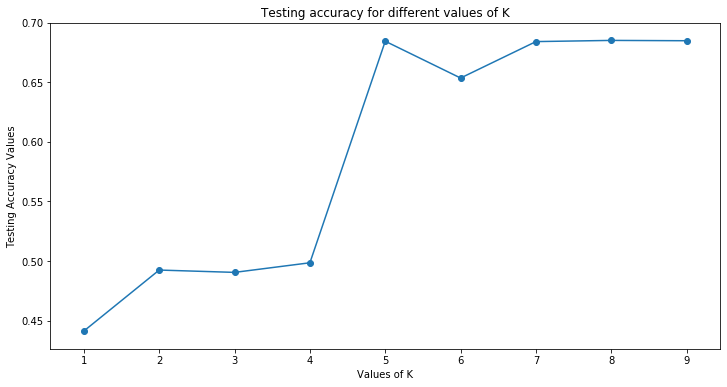

In [133]:
plt.figure(figsize=(12,6))
plt.title("Testing accuracy for different values of K")
plt.plot(ks, mean_accuracy)
plt.scatter(ks, mean_accuracy)
plt.xlabel('Values of K')
plt.ylabel('Testing Accuracy Values')

In [146]:
knn_model = knn(n_neighbors = 5)
knn_model.fit(X_train, y_train)
knn_yhat = knn_model.predict(X_test)
print(accuracy_score(y_test, knn_yhat))

0.6844706851572154


### 4.2 Decision Tree Classifier

In [215]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [216]:
maxDepth = 10
jaccards = []
f1s = []

for n in range(1,maxDepth):
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    drugTree.fit(X_train,y_train)
    predTree = drugTree.predict(X_test)
    f1s.append(f1_score(y_test, predTree, average='weighted'))
    jaccards.append(jaccard_similarity_score(y_test, predTree))

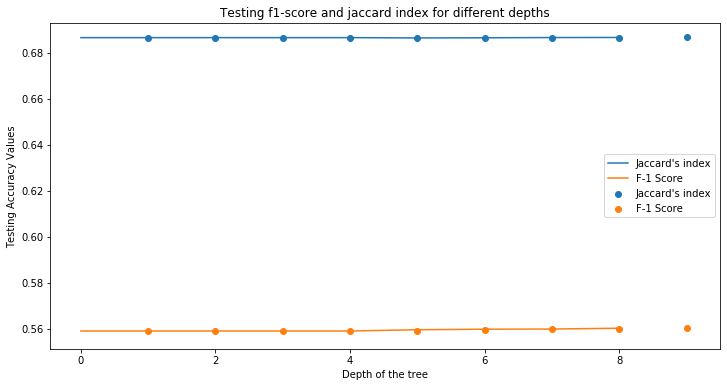

In [218]:
plt.figure(figsize=(12,6))
plt.title("Testing f1-score and jaccard index for different depths")
plt.xlabel('Depth of the tree')  
plt.ylabel('Testing Accuracy Values')
plt.plot(jaccards, label = "Jaccard's index")
plt.scatter(range(1,maxDepth),jaccards, label = "Jaccard's index")
plt.plot(f1s, label = "F-1 Score")
plt.scatter(range(1,maxDepth),f1s, label = "F-1 Score")
plt.legend()
plt.show()

The range of variation between the output it's a really small values

In [141]:
max(jaccards)-min(jaccards)

0.000205959082795526

In [229]:
max(jaccards)

0.6867019085541672

### 4.3 SVM Classifier

In [57]:
from sklearn.svm import SVC 
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
accuracy_score = []

for k in kernel_func:
    svc_model = SVC(C = 0.01, gamma = 'auto', kernel = k)
    svc_model.fit(X_train, y_train)
    svc_yhat = svc_model.predict(X_test)
    accuracy_score.append(f1_score(y_test, svc_yhat, average = 'weighted'))

Text(0, 0.5, 'Testing Accuracy Values')

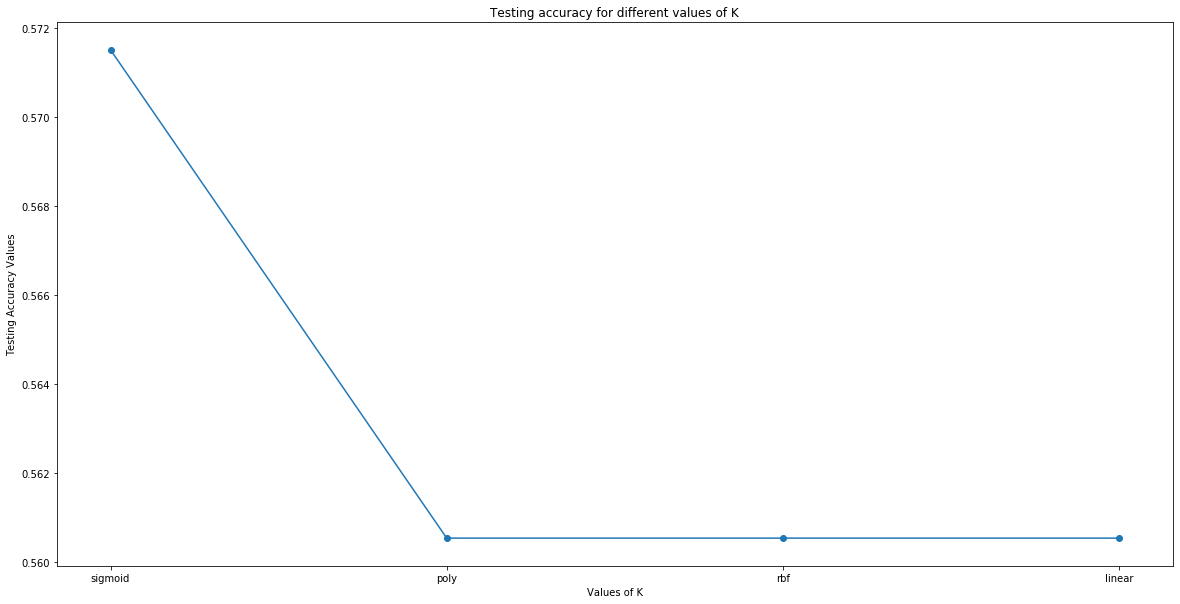

In [59]:
plt.figure(figsize=(12,6))
plt.title("Testing accuracy for different values of K")
plt.plot(kernel_func, accuracy_score)
plt.scatter(kernel_func, accuracy_score)
plt.xlabel('Values of K')
plt.ylabel('Testing Accuracy Values')

In [222]:
svc_model = SVC(C = 0.01, gamma = 'auto', kernel = 'sigmoid')
svc_model.fit(X_train, y_train)
svc_yhat = svc_model.predict(X_test)
print(f1_score(y_test, svc_yhat, average = 'weighted'))

0.5160782449179411


### 4.4 Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = [{'C':[1,0.1,0.01,0.001,0.0001],
           'solver':['liblinear', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
           }]
LR = LogisticRegression()
LR_Grid = GridSearchCV(LR, parameters,cv=4)
LR_Grid.fit(X_train,y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 0.1, 0.01, 0.001, 0.0001],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs',
                                     'liblinear', 'sag', 'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [66]:
print(f'Grid Search yielded the best score for logistic regression as : {LR_Grid.best_score_} with parameters : {LR_Grid.best_params_}')

Grid Search yielded the best score for logistic regression as : 0.6861585805412019 with parameters : {'C': 1, 'solver': 'liblinear'}


In [224]:
LR_model = LogisticRegression(C = 1, solver ='liblinear').fit(X_train, y_train)
lr_yhat = LR_model.predict(X_test)

In [225]:
print(f1_score(y_test, lr_yhat, average = 'weighted'))

0.5593789865097983


# 5. Conclusion

From all the models above, the Decision Tree classifier was the most accurate classifier, also this algorithm is chosen for its interpretability, also is the fastest from the shown here. Since all the depth levels have almost the same accuracy, the depth chosen level is for. From the plot bellow we can estimate what are the most important factors in the classification category, hence the most significant variables in the severity of the accident. The first 4 factors in order of significance are:
1. Road conditions
2. Light conditions
3. Influence of alcohol or drugs
4. Weather
*For document size capacity, the tree classifier was inly displayed for a two depth model plot

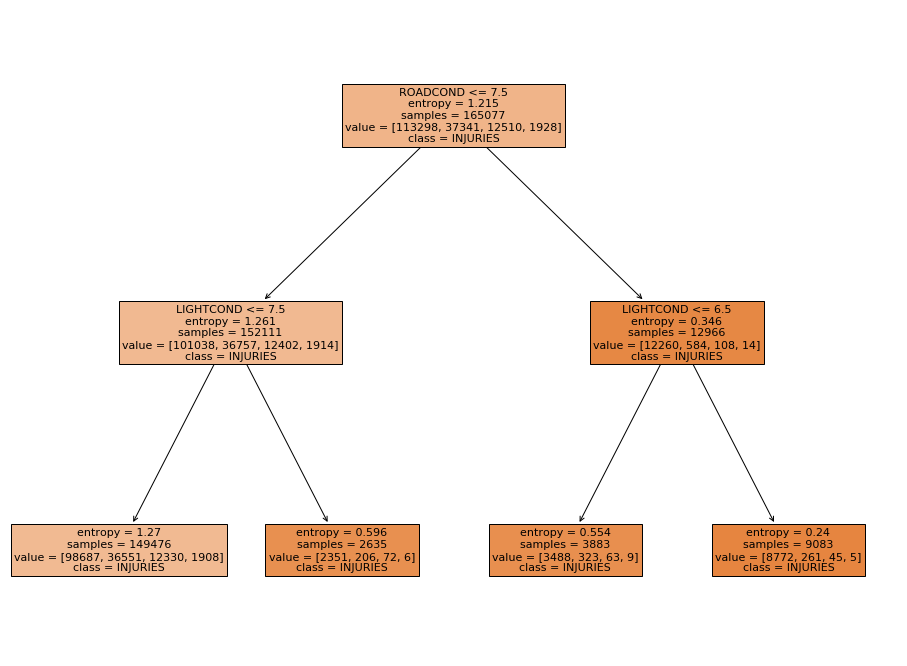

In [235]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 2)
clf = clf.fit(X_train,y_train)
fig = plt.figure(figsize=(16,12))
_ = tree.plot_tree(clf,
                  feature_names = ['UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING'],
                  class_names = ['INJURIES','SERIOUSINJURIES','FATALITIES'],
                  filled = True)

In [210]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 4)
clf = clf.fit(X_train,y_train)

Finally, two cases are predicted as an example of the interpretablity of the model of probabilities of the accident severity and how it is built. From the input, one person is able to estimate an expected probability for driving depending on the conditions of the environment for that particular case. The corresponding input is built from the answers of the following questions.


a.- ¿Are you drunk or under the influence of drugs?
    1. Yes
    2. No
    
b.- What's the weather like?
    1. Clear
    2. Raining
    3. Overcast
    4. Snowing
    5. Fog/Smog/Smoke
    6. Sleet/Hail/Freezing Rain
    7. Blowing Sand/Dirt
    8. Severe Crosswind
    9. Partly Cloudy
    10. Other/Unknown

c.- How would you define the road conditions?
    1. Dry
    2. Wet
    3. Ice
    4. Snow/Slush
    5. Standing water
    6. Sand/Mud/Dirt
    7. Oil
    8. Other/Unknown

d. What are the light conditions?
    1. Daylight
    2. Dark – Street Lights On
    3. Unknown
    4. Dusk
    5. Dawn
    6. Dark – No Street Lights
    7. Dark – Street Lights On
    8. Dark – Unknown Lighting
    9. Other

e.- Are you in a hurry? Is it possible that you exceed the speed limit during your travel?
    1. Yes
    2. No    

Now, we'll test the probabilities for three cases:
- Optimistic scenario (0 2 1 1 0): No alcohol or drug influence, Partly cloudy weather, Dry road conditions, Daylight and no speed limit exceeded.
- Pessimistic scenario (1, 5, 4, 6, 1): Alcohol or drug influence, Fog/Smog/Smoke,standing water road conditions, dark - street lights off, speed limit exceeded.

Optimistic scenario:

In [211]:
clf.predict_proba([[0, 2, 1, 1, 0]])

array([[0.66790953, 0.24217256, 0.07960288, 0.01031503]])

Pessimistic scenario:

In [213]:
clf.predict_proba([[1, 5, 4, 6, 1]])

array([[0.45677966, 0.31186441, 0.15847458, 0.07288136]])

For these scneario, of there is an accident the probababilities for the severity accidents are:

Optimistic scenario:
- Type 1 = 66.79%,
- Type 2 = 24.21%
- Type 3 = 7.96%
- Type 4 = 1.03%
Pessimistic scenario:
- Type 1 = 45.67%,
- Type 2 = 31.18%
- Type 3 = 15.84%
- Type 4 = 7.28%

The severity accidents are:
1. Type 1 (0 - 4): No incident or a few car crashes with no injuries or fatalities.
2. Type 2 (5 - 9): One injured person and multiple car crashes.
3. Type 3 (10 - 20): Multiple Injuries or a serious injured person, with multiple car crashes.
4. Type 4 (>20): Sever accident. A lot of injured persons, more than one serious injured person or a fatality occurred

## 6. Discusion

a. Even though the prediction model gives reasonable results, the accuracy can be improved by changing different forms of measuring the severity of an accident since it’s really hard to find a way of predicting the severity of a road accident.
b. A better prediction can be made by getting more data. Also getting more data of no incident drives.
c. Using a different scale for the severity of a possible accident, different to the created here, could help for the accuracy of the predictions and a better

## 7. References

ASIRT, 2020 (Association for Safe International Road Travel): Annual United States Road Crash Statistics https://www.asirt.org/safe-travel/road-safety-facts/